In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_dir="D:\\AI Project\\kidney cancer\\data\\train"
test_dir="D:\\AI Project\\kidney cancer\\data\\test"

datagn=ImageDataGenerator(rescale=1/255,validation_split=0.2,zoom_range=.7,shear_range=.2,rotation_range=.3)
test_datagn=ImageDataGenerator(rescale=1/255)


train_set=datagn.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=4,
    class_mode="categorical",
    subset="training"
    )

valid_set=datagn.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=4,
    class_mode="categorical",
    subset="validation"
)

test_set=test_datagn.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical"
)

Found 7829 images belonging to 2 classes.
Found 1956 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [3]:
from keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Uses float16 for calculations where possible

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [4]:
train_set.class_indices

{'kidney_normal': 0, 'kidney_tumor': 1}

In [5]:
labels=['Normal','Tumor']
print(labels)

['Normal', 'Tumor']


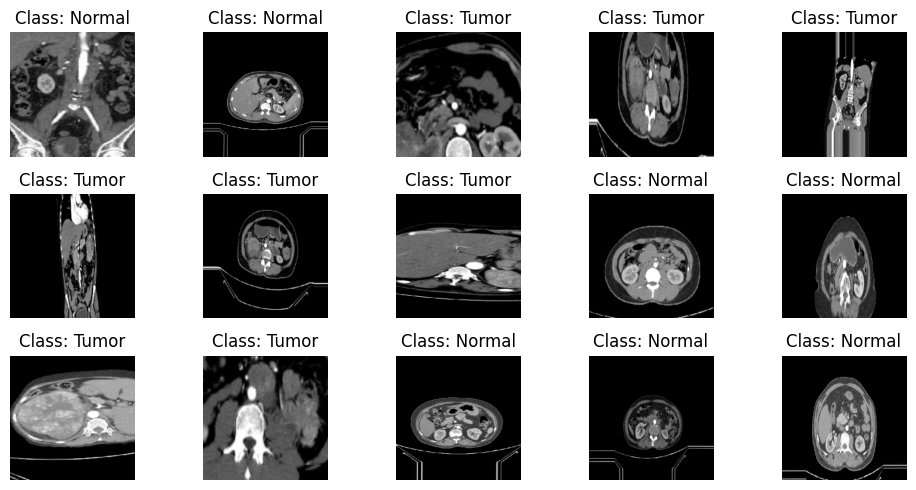

In [6]:
plt.figure(figsize=(10, 5))

for i in range(15):  
    plt.subplot(3, 5, i+1) 
    image, label = train_set.next()  
    plt.imshow(image[0])  
    plt.axis("off")  
    plt.title(f"Class: {labels[np.argmax(label)]}") 

plt.tight_layout()  
plt.show()

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

# Add new top layers for our specific classification problem
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(2, activation='softmax')(x)

In [8]:
# Compile the model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_set,
                    epochs=10,
                    validation_data=valid_set,
                    verbose=1)

print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])

Epoch 1/10
1958/1958 [==============================] - 81s 38ms/step - loss: 0.3020 - accuracy: 0.8834 - val_loss: 0.5296 - val_accuracy: 0.7914
Epoch 2/10
1958/1958 [==============================] - 72s 37ms/step - loss: 0.1201 - accuracy: 0.9533 - val_loss: 0.1523 - val_accuracy: 0.9407
Epoch 3/10
1958/1958 [==============================] - 72s 37ms/step - loss: 0.0866 - accuracy: 0.9676 - val_loss: 0.1187 - val_accuracy: 0.9535
Epoch 4/10
1958/1958 [==============================] - 72s 37ms/step - loss: 0.0707 - accuracy: 0.9737 - val_loss: 0.4687 - val_accuracy: 0.8390
Epoch 5/10
1958/1958 [==============================] - 72s 37ms/step - loss: 0.0714 - accuracy: 0.9739 - val_loss: 0.1928 - val_accuracy: 0.9228
Epoch 6/10
1958/1958 [==============================] - 72s 37ms/step - loss: 0.0606 - accuracy: 0.9783 - val_loss: 0.0919 - val_accuracy: 0.9652
Epoch 7/10
1958/1958 [==============================] - 73s 37ms/step - loss: 0.0567 - accuracy: 0.9806 - val_loss: 0.1902 -

In [9]:
test_loss,test_acc=model.evaluate(test_set)
print(test_acc)

9/9 [==============================] - 2s 76ms/step - loss: 0.0137 - accuracy: 0.9962
0.9961538314819336


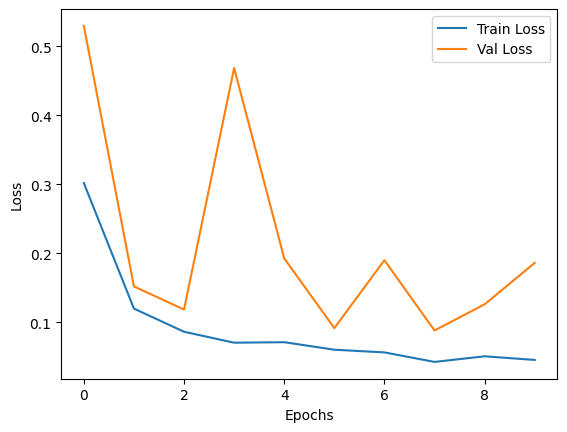

In [10]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.show()

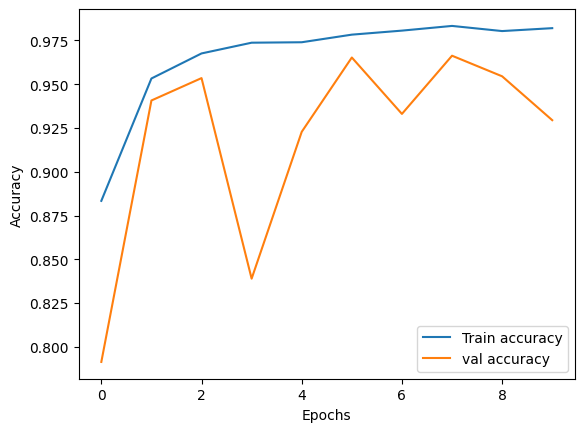

In [11]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.show()

In [12]:
model.save("kidney_cancer.h5")